# Quick benchmark

In [2]:
@everywhere using Distributions
@everywhere using Base.Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
using MCMCDiagnostics
cd("../Source/")
@everywhere include("types.jl")
@everywhere include("functions_msc.jl")
@everywhere include("functions_neighbors.jl")
@everywhere include("functions_types.jl")
@everywhere include("functions_energy.jl")
@everywhere include("functions_mc.jl")
@everywhere include("functions_thermalization.jl")
@everywhere include("functions_observables.jl")
include("functions_plots_and_files.jl")
cd("../Notebooks/")
using Plots
pyplot()

Plots.PyPlotBackend()

In [8]:
THERM_FRAC = 1/10
DT_MAX = 10000

@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = 0.005   # External field

# Other parameters
L = 12     # System length
L₃ = 12
T = 0.02 #0.11039   # Temperature
κ₅ = 1.0

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
f = 1.0/L
println("f set to $(f)")
# Calculate inverse temperature
β = 1/T
println("β set to $(β)")

# Create system
syst = SystConstants(L, L₃, 1/g^2, ν, κ₅, f, β)
sim = Controls(π/3, 0.4, 3.0) # pi - pi/12

# Measurement parameters
M = 600    # Number of measurements
Δt = 1000  # Interval between measurements (MCS)
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];

f set to 0.08333333333333333
β set to 50.0


In [6]:
ψ = State(2, syst);
@benchmark fᵣ(ψ.lattice[1,1], ψ.nb[1,1], 1, syst)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     648.626 ns (0.00% GC)
  median time:      940.468 ns (0.00% GC)
  mean time:        944.225 ns (0.21% GC)
  maximum time:     20.931 μs (92.90% GC)
  --------------
  samples:          10000
  evals/sample:     171

In [7]:
@benchmark fᵣInefficient(ψ.lattice[1,1], ψ.nb[1,1], 1, syst)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     639.388 ns (0.00% GC)
  median time:      925.173 ns (0.00% GC)
  mean time:        930.662 ns (0.00% GC)
  maximum time:     52.020 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     49

In [10]:
@test fᵣ(ψ.lattice[1,1], ψ.nb[1,1], 1, syst) == fᵣInefficient(ψ.lattice[1,1], ψ.nb[1,1], 1, syst)

Test Passed

In [9]:
println("\nTesting Energy difference function ΔE\n----------------------------------------------------------------")
# Test case. We make a random 3x3 lattice, and put two different lattice sites in the middle
# i.e. the [2,2] position. Then we use the different functions to calculate the energy
# difference associated with this change.

ψ₂ = State(2,syst)
ϕ′ = LatticeSite() # Get random lattice site
ψ₁ = copy(ψ₂)
@test ψ₁.nb[3,2,2].ϕᵣ₊₂.u⁺ == ψ₁.lattice[2,2,2].u⁺
@test ψ₁.nb[3,2,2].ϕᵣ₊₂ == ψ₁.lattice[2,2,2]
set!(ψ₁.lattice[2,2,2], ϕ′)
@test ψ₁.nb[3,2,2].ϕᵣ₊₂.u⁺ == ϕ′.u⁺

dE = ΔE(ϕ′,ψ₂.lattice[2,2,2],ψ₂.nb[2,2,2],ψ₂.nnb[2,2,2],ψ₂.nnnb[2,2,2], 2,ψ₂.consts)
println("Checking that ΔE and E get same result")
println(@test testEnDiff(ψ₂, ψ₁, dE))
#println(@test isapprox(E(ψ₁)-E(ψ₂), dE; atol=0, rtol=1e-13))



Testing Energy difference function ΔE
----------------------------------------------------------------
Checking that ΔE and E get same result
Test Passed


In [10]:
ψ₀ = State(2, syst)
println("Checking that ΔE gives same result as E'-E on all different sites of the lattice")
ψ = copy(ψ₀)
for z_pos = 1:L, h_pos = 1:L, v_pos = 1:L
    ψ = copy(ψ₀)
    ϕ′ = LatticeSite()
    dE = ΔE(ϕ′, ψ₀.lattice[v_pos,h_pos,z_pos],ψ₀.nb[v_pos,h_pos,z_pos],ψ₀.nnb[v_pos,h_pos,z_pos],ψ₀.nnnb[v_pos,h_pos,z_pos],h_pos,ψ₀.consts)
    set!(ψ.lattice[v_pos,h_pos,z_pos], ϕ′)
    if !testEnDiff(ψ₀, ψ, dE)
        println("[$(v_pos), $(h_pos), $(z_pos)]")
    end
    #@test isapprox(E(ψ₁)-E(ψ₂), dE; atol=0, rtol=1e-13)
end
println(@test isapprox(E(ψ)-dE, E(ψ₀); atol=0, rtol=1e-13))



Checking that ΔE gives same result as E'-E on all different sites of the lattice
Test Passed



signal (15): Terminated
while loading /home/nicolai/.julia/v0.6/IJulia/src/kernel.jl, in expression starting on line 38
syscall at /lib/x86_64-linux-gnu/libc.so.6 (unknown line)
uv__epoll_wait at /buildworker/worker/package_linux64/build/deps/srccache/libuv-d8ab1c6a33e77bf155facb54215dd8798e13825d/src/unix/linux-syscalls.c:321
uv__io_poll at /buildworker/worker/package_linux64/build/deps/srccache/libuv-d8ab1c6a33e77bf155facb54215dd8798e13825d/src/unix/linux-core.c:267
uv_run at /buildworker/worker/package_linux64/build/deps/srccache/libuv-d8ab1c6a33e77bf155facb54215dd8798e13825d/src/unix/core.c:354


### Written requirements

We want a thermalization algorithm that doesn't fail like the previous one. This means that if it is unable to find a thermalization time where the average of the energy graph is within one standard deviation of the other averages then we look at the slope of the energy graphs. If the energy graphs have flattened out and the average energy difference is the same as the previously calculated (again within some standard deviation), then we can assume that we have hit some kind of domain wall which we will not be able to recover from and thus end the thermalization with a warning.

When it comes to files we would also like the thermalization algorithm to look in the current folder for states `init_ref.state` and `init_workers.statelist` and if they exist use these as the staring point for the reference state and the worker states respectively.

As the thermalization algorithm proceeds, we also want to periodically save the states in files `therm_temp_ref.state` and `therm_temp_workers.statelist`. If the thermalization is successful, we delete these files and save the then thermalized states in `therm_ref.state` and `therm_workers.statelist`.

In [12]:
N_SUBS = 3
L = 41
L_s = floor(Int64, L/N_SUBS)
println(L_s)
L-N_SUBS*L_s == L%N_SUBS

13


true

In [3]:
# --------------------------------------------------------------------------------------------------
# A series of measurements produced by MC Monte Carlo calculations, calculate the average and error
# of the array.
function avgErr{T<:Real}(A::Array{T,1})
    avg_A = mean(A)
    sm_A = 0.0
    M = length(A)
    for m = 1:M
        sm_A += A[m]^2
    end
    sm_A = sm_A/M
    τ = M/effective_sample_size(A)
    err_A = sqrt((1+2*τ)*abs(sm_A - avg_A^2)/(M-1))
    
    return avg_A, err_A
end


avgErr (generic function with 2 methods)

In [24]:
M = 10000
scientificRounding(avgErr(rand(M))...)

(0.497, 0.005)

In [4]:
function flatThermalization{T<:Real}(E_list::Array{T, 1}; N_SUBS=3, ERR_WEIGHT=2.0)
    L = length(E_list)
    
    # Length of the first N_SUBS-1 intervals
    L_s⁻ = floor(Int64, L/N_SUBS)
    # Length of the last interval
    L_s⁺ = L_s⁻ + L%N_SUBS
    
    E_avg = Array{Float64, 1}(N_SUBS)
    E_err = Array{Float64, 1}(N_SUBS)
    
    # Calculate average for the first N_SUBS-1 intervals
    for s = 1:N_SUBS-1
        int = 1 + (s-1)*L_s⁻:s*L_s⁻
        E_avg[s], E_err[s] = avgErr(E_list[int])
    end
    # Last interval
    int = 1 + (N_SUBS-1)*L_s⁻:(N_SUBS-1)*L_s⁻ + L_s⁺
    E_avg[N_SUBS], E_err[N_SUBS] = avgErr(E_list[int])
    
    # Check if all interval averages are within max error of first interval average
    # Return if we find non-flat average
    for s = 2:N_SUBS
        error = max(E_err[s], E_err[1])
        if abs(E_avg[s] - E_avg[1]) > ERR_WEIGHT*error
            return false, E_avg[s], E_avg[1], error
        end
    end
    
    # If we got through previous loop it means that all averages are within error and the
    # energy-curves must be flat.
    return true, E_avg[N_SUBS], E_avg[1], max(E_err[N_SUBS], E_err[1])
end  

flatThermalization (generic function with 1 method)

In [36]:
function flatThermalization(E_w::Array{Float64, 2}; N_SUBS=3, visible=false)
    nw = size(E_w, 1)
    
    # Setup storage
    avg_last = Array{Float64, 1}(nw); avg_first = Array{Float64, 1}(nw); err = Array{Float64, 1}(nw)
    
    # Go through all workers and check if their energies are flat
    for w = 1:nw
        isflat, avg_last[w], avg_first[w], err[w] = flatThermalization(E_w[w, :]; N_SUBS=N_SUBS)
        if !isflat
            if visible
                println("Worker $(w) not flat.\t⟨ΔE⟩ = $(avg_last[w]-avg_first[w]) ± $(err[w])")
            end
            return false
        end
    end
    
    # All workers must be flat
    if visible
        println("\nAll workers flat.")
        for w = 1:nw
            println("  ⟨ΔE⟩{$(w)} =\t$(avg_last[w]-avg_first[w]) ± $(err[w])")
        end
    end
    return true
end

flatThermalization (generic function with 2 methods)

In [81]:
flatThermalization(rand(4,10); visible=true)

true

In [84]:
flatThermalization([h*√(2) for v = 1:4, h = 1:100]; visible=true)

Worker 1 not flat:	94.04520189781083 ± 14.982669727283607


false

In [6]:
function thermalizeToZero!(ψ_ref::State, ψ_w::Array{State, 1}, sim_ref::Controls, sim_w::Array{Controls,1},
        T_QUENCH::Int64; GROWTH_EX=1.5, INIT_T=100)
    T = min(T_QUENCH, INIT_T) # This is the number of steps to do initially
    
    nw = length(ψ_w)
    ψ_future_list = [Future() for i=1:nw]
    
    # Setup storage
    E_ref = Array{Float64, 1}(T_QUENCH)
    E_w = Array{Float64, 2}(nw, T_QUENCH)
    E_check_workers = zeros(Int64, nw)
    
    # Checking whether reference or worker has highest energy.
    ref_highest = [true for i = 1:nw]
    E_ref[1] = E(ψ_ref)
    for w = 1:nw
        E_w[w,1] = E(ψ_w[w])
        if E_w[w,1]>E_ref[1]
            ref_highest[w] = false
        end
    end
    t = 1 # The previously occupied index in the energy arrays
    
    # Do the T_QUENCH MCS updates and store resulting energy
    
    # First grow the number to keep doing MCS with, by a factor GROWTH_EX from the initial T = INIT_T
    # until we have grown to T_QUENCH
    while t < T_QUENCH
        # Do T MCS and store resulting energy
        for w = 1:nw
            ψ_future_list[w] = @spawn nMCSEnergy(ψ_w[w], sim_w[w], T, E_w[w,t])
        end
        ψ_ref, E_ref[t+1:t+T] = nMCSEnergy(ψ_ref, sim_ref, T, E_ref[t])
        for w = 1:nw
            ψ_w[w], E_w[w,t+1:t+T] = fetch(ψ_future_list[w])
        end
        
        # Check for first zero
        for w = 1:nw
            ψ_future_list[w] = @spawn firstZero(E_ref, E_w, w, t+1, t+T, ref_highest[w])
        end
        for w = 1:nw
            i = fetch(ψ_future_list[w])
            if i != -1
                E_check_workers[w] = i
                println("Worker $(w) initially thermalised after $(i) steps")
                flush(STDOUT)
            end
        end

        t = t+T # Setting t to be the last occupied element in lists after inserting T results.
        if minimum(E_check_workers) == 0 # This is always true if we found no dE < 0 in all workers
            T = min(ceil(Int64, T*GROWTH_EX), T_QUENCH-t) # Updating until we have done T_QUENCH updates.
        else
            t_final = maximum(E_check_workers)
            println("All workers initially thermalized after $(t_final) steps")
            flush(STDOUT)
            return t_final, ψ_ref, E_ref[1:t], ψ_w, E_w[:,1:t]
        end
    end
    
    println("Warning: Couldn't find ΔE = 0 after $(t) steps.")
    return t, ψ_ref, E_ref, ψ_w, E_w
end

thermalizeToZero! (generic function with 1 method)

 49.998692 seconds (90.68 M allocations: 4.477 GiB, 5.05% gc time)


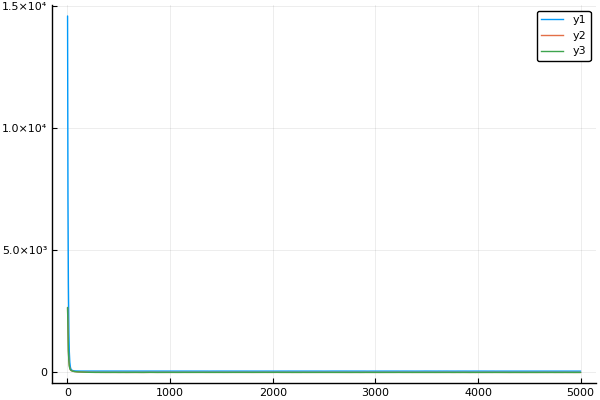

In [21]:
T_QUENCH = 5000
nw = nprocs()-1
@time t, ψ_ref, E_ref, ψ_w, E_w = thermalizeToZero!(State(2, syst),
    [State(1, syst) for i = 1:nw], sim, [sim for i = 1:nw], T_QUENCH);
plot(1:length(E_ref), [E_ref, [E_w[w,:] for w = 1:size(E_w,1)]...])

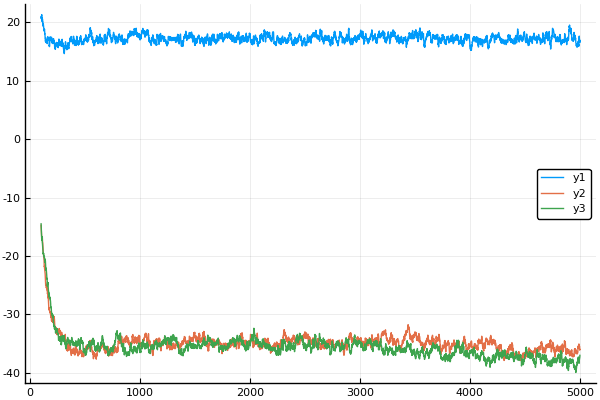

In [22]:
int = 100:5000
plot(int, [E_ref[int], [E_w[w,int] for w = 1:size(E_w,1)]...])

In [8]:
function nMCS!(ψ_list::Array{State, 1}, sim_list::Array{Controls, 1}, N::Int64)
    nw = nprocs()-1
    n_state = length(ψ_list)
    
    i = 0 # Index in ψ_list of states already updated.
    while i < n_state
        
        worker_jobs = min(nw, n_state-1-i) # Number of needed jobs given to workers
        # Start the max number of workers if that wouldn't be too much.
        work_futures = [Future() for w = 1:worker_jobs]
        
        for w = 1:worker_jobs
            work_futures[w] = @spawn nMCS(ψ_list[i+w], sim_list[i+w], N)
        end
        nMCS(ψ_list[i+worker_jobs+1], sim_list[i+worker_jobs+1], N)
        
        for w = 1:worker_jobs
            ψ_list[i+w] = fetch(work_futures[w])
        end
        
        i += worker_jobs+1
    end
    
    # After this, all states should have been updated
    return ψ_list
end

nMCS! (generic function with 1 method)

In [23]:
n_state = 5
ψ_list = [State(2, syst) for i = 1:n_state];
sim_list = [copy(sim) for i = 1:n_state]
println(E(ψ_list[5]))
nMCS!(ψ_list, sim_list, 1000)
println(E(ψ_list[5]))

15010.8667111951
17.425402857407246


In [15]:
include("../Source/functions_mc.jl")

adjustSimConstants! (generic function with 3 methods)

In [15]:
function adjustSimConstants!(ψ_list::Array{State, 1}, sim_list::Array{Controls, 1})
    nw = nprocs()-1
    n_state = length(ψ_list)
    mcs_list = zeros(Int64, n_state)
    ar_list = Array{Float64, 1}(n_state)
    
    i = 0 # Index in ψ_list of states already updated.
    while i < n_state
        
        worker_jobs = min(nw, n_state-1-i) # Number of needed jobs given to workers
        # Start the max number of workers if that wouldn't be too much.
        work_futures = [Future() for w = 1:worker_jobs]
        
        for w = 1:worker_jobs
            work_futures[w] = @spawn adjustSimConstants!(sim_list[i+w], ψ_list[i+w])
        end
        index = i+worker_jobs+1
        ar_list[index], mcs_list[index], ψ_list[index], sim_list[index] = adjustSimConstants!(sim_list[index],
            ψ_list[index])
        
        # Fetch futures
        for w = 1:worker_jobs
            ar_list[i+w], mcs_list[i+w], ψ_list[i+w], sim_list[i+w] = fetch(work_futures[w])
        end
        
        i += worker_jobs+1
    end
    
    # After this, all states should have been updated
    return mcs_list, ar_list
end

adjustSimConstants! (generic function with 3 methods)

In [16]:
ψ_list = [State(2,syst), State(1, syst), State(2, syst)];
sim_list = [copy(sim) for i = 1:3]
adjustSimConstants!(ψ_list, sim_list)

([1640, 2120, 1640], [0.313614, 0.307407, 0.314931])

In [19]:
function printSimControls(sim_list::Array{Controls})
    println("State\tθmax\t\t\tumax\tAmax")
    for i = 1:length(sim_list)
        println("$i\t$(sim_list[i].θmax)\t$(sim_list[i].umax)\t$(sim_list[i].Amax)")
    end
    return
end

printSimControls (generic function with 1 method)

In [11]:
function nMCSEnergy!(ψ_list::Array{State, 1}, sim_list::Array{Controls, 1}, n::Int64, E₀_list::Array{Float64, 1})
    nw = nprocs()-1
    n_state = length(ψ_list)
    E_matrix = Array{Float64, 2}(n_state, n)
    
    i = 0 # Index in ψ_list of states already updated.
    while i < n_state
        
        worker_jobs = min(nw, n_state-1-i) # Number of needed jobs given to workers
        # Start the max number of workers if that wouldn't be too much.
        work_futures = [Future() for w = 1:worker_jobs]
        
        for w = 1:worker_jobs
            work_futures[w] = @spawn nMCSEnergy(ψ_list[i+w], sim_list[i+w], n, E₀_list[i+w])
        end
        index = i+worker_jobs+1
        ψ_list[index], E_matrix[index, :] =  nMCSEnergy(ψ_list[index], sim_list[index], n, E₀_list[index])
        
        for w = 1:worker_jobs
            ψ_list[i+w], E_matrix[i+w, :] = fetch(work_futures[w])
        end
        
        i += worker_jobs+1
    end
    
    # After this, all states should have been updated
    return ψ_list, E_matrix
end

nMCSEnergy! (generic function with 1 method)

In [50]:
function flatThermalization!(ψ_list::Array{State,1}, sim_list::Array{Controls, 1}; 
        T_AVG = 2000, N_SUBS = 3, CUTOFF_MAX=400000, T_QUENCH=1000, visible=false, 
        temp_states_filename="therm_temp.statelist")
    
    # Setup storage
    adjustment_mcs = 0
    n_state = length(ψ_list)
    E_matrix = Array{Float64, 2}(n_state, T_AVG)
    ψ_future_list = [Future() for i = 1:n_state]
    
    # Check whether we have enough processes for efficiency
    n_workers = nprocs()-1
    if n_state > n_workers+1
        println("WARNING: More requested states ($(n_state)), than currently available extra processes ($(n_workers+1)).
Thermalization will be ×$(floor(Int64, n_state/(n_workers+1))) as long.")
    end
    
    # First we quench the states with T_QUENCH MCS
    ψ_list = nMCS!(ψ_list, sim_list, T_QUENCH)
    
    # Adjust simulation constants
    mcs_list, ar_list = adjustSimConstants!(ψ_list, sim_list)
    adjustment_mcs += maximum(mcs_list)
    if visible
        println("Controls after initial adjustment:")
        printSimControls(sim_list)
        println("With lowest AR: $(minimum(ar_list)),\thighest AR: $(maximum(ar_list))\n")
    end
    
    # Go T_AVG at a time until we reach CUTOFF_MAX
    t = T_QUENCH # How many MCS we have used on making the states flat (except adjustments)
    while t < CUTOFF_MAX
        
        # Preform T_AVG updates and store energies for flatness calculation
        ψ_list, E_matrix = nMCSEnergy!(ψ_list, sim_list, T_AVG, [E(ψ) for ψ in ψ_list])
        
        # Adjust constants
        mcs_list, ar_list = adjustSimConstants!(ψ_list, sim_list)
        adjustment_mcs += maximum(mcs_list)
        
        # Save temporary state-files
        save(ψ_list, temp_states_filename)
        
        # Check if we have thermalization
        if flatThermalization(E_matrix; visible=visible, N_SUBS=N_SUBS)
            if visible
                println("All state energy-curves are flat after $(t+T_AVG+adjustment_mcs)\n\nFinal control constants:")
                printSimControls(sim_list)
                println("With lowest AR: $(minimum(ar_list)),\thighest AR: $(maximum(ar_list))")
            end
            return true, t+T_AVG+adjustment_mcs, ψ_list, sim_list, E_matrix
        end
        
        if visible
            println("Thermalization not yet reached after $(t) MCS")
        end
        t += T_AVG
    end
    
    # Couldn't find flat thermalization after CUTOFF_MAX MCS
    if visible
        println("Warning: cutoff reached after $(t-T_AVG) MCS. No thermalization found.")
    end
    return false, t-T_AVG+adjustment_mcs, ψ_list, sim_list, E_matrix
end

flatThermalization! (generic function with 1 method)

In [42]:
ψ_list = [State(2,syst), State(1, syst), State(2, syst)];
sim_list = [copy(sim) for i = 1:3]
_, t₀, ψ_list, sim_list, E_matrix = flatThermalization!(ψ_list, sim_list; visible=true);

Controls after initial adjustment:
State	θmax			umax	Amax
1	1.0471975511965976	0.11851851851851852	3.0
2	1.0471975511965976	0.07901234567901234	3.0
3	1.0471975511965976	0.11851851851851852	3.0
With lowest AR: 0.307421875,	highest AR: 0.319921875

Worker 1 not flat.	⟨ΔE⟩ = 0.1969005439894964 ± 0.08334507927475877
Thermalization not yet reached after 1000 MCS
Worker 2 not flat.	⟨ΔE⟩ = -4.139346449619751 ± 1.4615282346562943
Thermalization not yet reached after 3000 MCS

All workers flat.
  ⟨ΔE⟩{1} =	-0.023638294258152115 ± 0.08038305229535794
  ⟨ΔE⟩{2} =	-0.09255334031865914 ± 0.1823948139225026
  ⟨ΔE⟩{3} =	0.05437772495393389 ± 0.081491190083811
All state energy-curves are flat after 11280

Final control constants:
State	θmax			umax	Amax
1	1.0471975511965976	0.11851851851851852	3.0
2	0.310280755910103	0.05925925925925926	3.0
3	1.0471975511965976	0.11851851851851852	3.0
With lowest AR: 0.3110243055555556,	highest AR: 0.3153935185185185


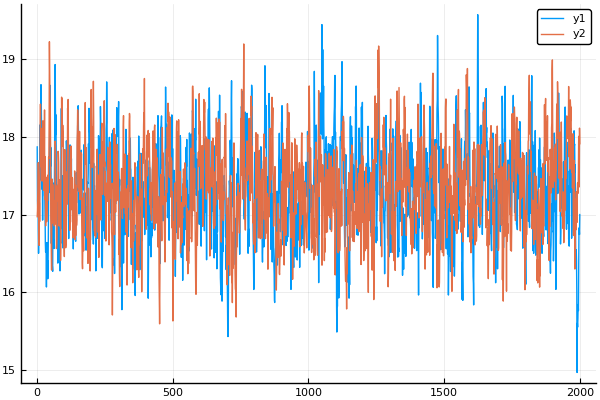

In [49]:
plot(1:size(E_matrix,2), [E_matrix[w,:] for w in [1,3]])

# Need to update this to the new logic of only updating simulation constants between averaging intervals

In [14]:
function thermalizeLite!(ψ_ref::State, ψ_w::Array{State,1}, sim::Controls; T_AVG = 2500, T_QUENCH = 1000,
        CUTOFF_MAX = 200000, N_SUBS=10, AVG_EX = 1.5, STABILITY_CUTOFF = 4000, ADJUST_INTERVAL = 400,
    temp_ref_filename="therm_temp_ref.state", temp_workers_filename="therm_temp_workers.statelist", visible=false)
    
    nw = length(ψ_w)
    # Setup storage
    E_ref = Array{Float64, 1}(T_AVG)
    ΔE_w = Array{Float64, 2}(nw, T_AVG)
    E_w = Array{Float64, 2}(nw, T_AVG)
    sim_ref = copy(sim)
    sim_w = [copy(sim) for i = 1:nw]
    
    mcs_ref = 0
    mcs_w = zeros(Int64, nw)
    adjustment_mcs = 0
    
    # Check whether we have enough processes for efficiency
    num_workers = nprocs()-1
    if nw > num_workers
        println("WARNING: More requested states ($(nw+1)), than currently available extra processes ($(num_workers+1)).
Thermalization will be ×$(floor(Int64, (nw+1)/(num_workers+1))) as long.")
    end
    
    # Preform initial quench, trying to find first ΔE=0
    t, ψ_ref, _1, ψ_w, _2 = thermalizeToZero!(ψ_ref, ψ_w, sim_ref, sim_w, T_QUENCH)
    
    # Collecting all states into one list for ease of referencing.
    ψ_list = [ψ_ref, ψ_w...]
    sim_list = [sim_ref, sim_w...]
    
    # Adjust simulation constants
    mcs_list, ar_list = adjustSimConstants!(ψ_list, sim_list)
    adjustment_mcs += maximum(mcs_list)
    if visible
        println("\nControls after initial adjustment:")
        printSimControls(sim_list)
        println("With lowest AR: $(minimum(ar_list)),\thighest AR: $(maximum(ar_list))")
    end
    
    # Make future list for the computations that will be done on ψ_w.
    ψ_future_list = [Future() for i=1:nw]
    
    while t < CUTOFF_MAX
        
        # Start by doing MCMC steps and saving the energies in the energy arrays until we have T_AVG energies.
        ψ_list, E_matrix = nMCSEnergy!(ψ_list, sim_list, T_AVG, [E(ψ) for ψ in ψ_list])
        E_ref = E_matrix[1,:]
        E_w = E_matrix[2:end, :]
        
        # Doing this for all the worker states
        #for w=1:nw
        #    ψ_future_list[w] = @spawn nMCSEnergy(ψ_w[w], sim_w[w], T_AVG, ADJUST_INTERVAL, E(ψ_w[w]))
        #end
        # Similar for the high T in master
        #ψ_ref, E_ref, sim_ref, mcs_ref = nMCSEnergyDynamic(ψ_ref, sim_ref, T_AVG, ADJUST_INTERVAL, E(ψ_ref))
        
        # Gather results from workers
        #for w=1:nw
        #    ψ_w[w], E_w[w,:], sim_w[w], mcs_w[w] = fetch(ψ_future_list[w])
        #    ΔE_w[w, :] = E_ref - E_w[w,:]
        #end
        
        # Finding energy differences
        for w = 1:nw
            ΔE_w[w,:] = E_ref-E_w[w,:]
        end
        
        # Save temporary state-files
        save(ψ_ref, temp_ref_filename)
        save(ψ_w, temp_workers_filename)
        
        # Check if we have thermalization
        if flatThermalization(ΔE_w; visible=visible)
            if checkThermalization(E_ref, E_w, 1, T_AVG)
                println("Final thermalization time: $(t+T_AVG+adjustment_mcs)")
                if visible
                    println("\nFinal controls:")
                    printSimControls(sim_list)
                    println("With lowest AR: $(minimum(ar_list)),\thighest AR: $(maximum(ar_list))")
                end
                return true, t+T_AVG+adjustment_mcs, ψ_ref, E_ref, sim_ref, ψ_w, E_w, sim_w
            elseif t+T_AVG > STABILITY_CUTOFF
                println("WARNING: Flat energy curves after $(t+T_AVG) MCS, but stabilized at different energies.
Jagged energy landscape?")
                if visible
                    println("\nFinal controls:")
                    printSimControls(sim_list)
                    println("With lowest AR: $(minimum(ar_list)),\thighest AR: $(maximum(ar_list))")
                end
                return false, t+T_AVG+adjustment_mcs, ψ_ref, E_ref, sim_ref, ψ_w, E_w, sim_w
            end
        end
        
        if visible
            println("Thermalization not yet reached after $(t+T_AVG) MCS")
        end
        
        # Adjust constants
        mcs_list, ar_list = adjustSimConstants!(ψ_list, sim_list)
        adjustment_mcs += max(maximum(mcs_w),mcs_ref)
        
        t += T_AVG
    end

    # If we get to this point we have completely given up on getting any flat thermalization.
    println("ERROR: Was not able to find point where energy curves were flat.")
    if visible
        println("\nFinal controls:")
        printSimControls(sim_list)
        println("With lowest AR: $(minimum(ar_list)),\thighest AR: $(maximum(ar_list))")
    end
    return false, t-T_AVG+adjustment_mcs, ψ_ref, E_ref, sim_ref, ψ_w, E_w, sim_w
end

thermalizeLite! (generic function with 1 method)

Worker 1 initially thermalised after 46 steps
Worker 2 initially thermalised after 38 steps
All workers initially thermalized after 46 steps

Controls after initial adjustment:
State	θmax			umax	Amax
1	1.0471975511965976	0.3666666666666667	3.0
2	1.0471975511965976	0.3666666666666667	3.0
3	1.0471975511965976	0.3666666666666667	3.0
With lowest AR: 0.3129195601851852,	highest AR: 0.31623263888888886

All workers flat.
  ⟨ΔE⟩{1} =	-0.031103750853006432 ± 0.13457905542926402
  ⟨ΔE⟩{2} =	-0.022893005195164108 ± 0.13140631035687922
Thermalization successful between T = [1, 2000]
Worker 1: ΔE = 0.03119232826256001 ± 0.8149431255913788
Worker 2: ΔE = 3.486633628853042e-5 ± 0.8648048519798399
Final thermalization time: 2606

Final controls:
State	θmax			umax	Amax
1	1.0471975511965976	0.3666666666666667	3.0
2	1.0471975511965976	0.3666666666666667	3.0
3	1.0471975511965976	0.3666666666666667	3.0
With lowest AR: 0.3129195601851852,	highest AR: 0.31623263888888886
 26.447707 seconds (47.83 M allocati

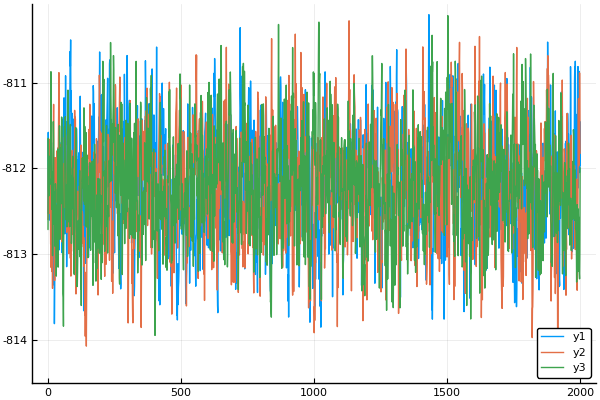

In [15]:
@time thermalized, t₀, ψ_ref, E_ref, sim_ref, ψ_w, E_w, sim_w = thermalizeLite!(State(2, syst),
    [State(1, syst) for i = 1:2], sim; T_AVG = 2000, visible=true);
plot(1:length(E_ref), [E_ref, [E_w[w,:] for w = 1:size(E_w,1)]...])

In [38]:
Controls(π/3, 0.4, 3.0)

Controls(1.0471975511965976, 0.4, 3.0, Distributions.Uniform{Float64}(a=-1.0471975511965976, b=1.0471975511965976), Distributions.Uniform{Float64}(a=-0.4, b=0.4), Distributions.Uniform{Float64}(a=-3.0, b=3.0))

In [41]:
sim_w[2]

Controls(0.3878509448876288, 0.023675458564544324, 3.0, Distributions.Uniform{Float64}(a=-0.3878509448876288, b=0.3878509448876288), Distributions.Uniform{Float64}(a=-0.023675458564544324, b=0.023675458564544324), Distributions.Uniform{Float64}(a=-3.0, b=3.0))

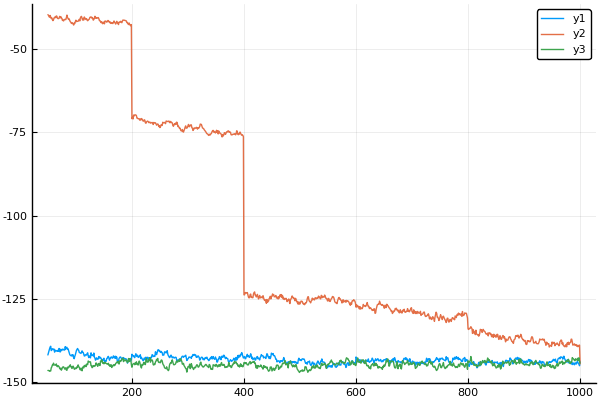

In [27]:
int = 50:1000
plot(int, [E_ref[int], [E_w[w,int] for w = 1:size(E_w,1)]...])

In [118]:
@time parallelThermalization!(State(2, syst), [State(1, syst) for i = 1:2], syst, sim);

Number of parallel workers: 2
Increasing simulation time such that tₛ = 1001 and T = 1802
Increasing simulation time such that tₛ = 1802 and T = 3244


LoadError: [91mInterruptException:[39m